## pyfkpt + CAMB: 1-loop RSD multipoles

In [1]:
# ---- imports (standard packages) ----
import os, tempfile
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

# ---- pyfkpt (new fkpt wrapper) ----
import pyfkpt.rsd as pyfkpt
    
# ---- CAMB: linear matter P(k) at z_pk ----
import camb
from camb import model
def camb_linear_pk(h, ombh2, omch2, omnuh2, As, ns, z, N_ur,
                   minkh=1e-4, maxkh=2.0, npoints=1000):
    mnu_eV = 93.14 * omnuh2          # single massive ν, sum mν = 93.14 Ων h^2
    pars = camb.set_params(
        H0=100*h, ombh2=ombh2, omch2=omch2,
        mnu=mnu_eV, nnu=N_ur, num_massive_neutrinos=1, As=As, ns=ns,
    )
    pars.set_matter_power(redshifts=[z], kmax=maxkh+0.05)
    pars.NonLinear = model.NonLinear_none
    res = camb.get_results(pars)
    k, _, pk = res.get_matter_power_spectrum(minkh=minkh, maxkh=maxkh, npoints=npoints)
    return k, pk[0]  # (Mpc/h)^3 at z


Define cosmology and nuisance parameters

In [3]:
# ---- cosmology & nuisance parameters ----
# cosmology (same as your example)
h      = 0.6711
ombh2  = 0.022
omch2  = 0.122
omnuh2 = 0.0006442
As     = 2e-9
ns     = 0.965
z_pk   = 0.5
N_ur   = 1.0 + 2.0328
Om     = (ombh2 + omch2 + omnuh2) / (h**2)
print("Omega_m:", Om)

# k-range for CAMB
khmin, khmax, nbk = 1.0e-4, 2.0, 1000

# nuisance vector (b1, b2, bs2, b3nl, EFT, stoch, shot)
b1 = 1.70               
b2 = -0.45
bs2  = -4/7*(b1 - 1)
b3nl = 32/315*(b1 - 1)

alpha0, alpha2, alpha4, ctilde = 3.0, -29.0, 0.0, 0.0
alpha0shot, alpha2shot, pshotp = 0.08, -8.0, 5000.0

nuis = [b1,b2,bs2,b3nl,alpha0,alpha2,alpha4,ctilde,alpha0shot,alpha2shot,pshotp]

Omega_m: 0.32116376920479256


Call camb to get the linear matter power spectrum

In [4]:
k_camb, pk_camb = camb_linear_pk(h, ombh2, omch2, omnuh2, As, ns, z_pk, N_ur,
                                 minkh=khmin, maxkh=khmax, npoints=nbk)

Compute 1-loop galaxy redshift power spectrum

In [5]:
# ---- pyfkpt: build FKPT tables in memory & get RSD multipoles ----
# Preferred: pass tables in-memory. If your installed pyfkpt lacks `tables=...`,
# we fall back to a TemporaryDirectory (auto-deleted).
params = dict(
    z=z_pk, Om=Om, h=h,
    b1=b1, b2=b2, bs2=bs2, b3nl=b3nl,
    alpha0=alpha0, alpha2=alpha2, alpha4=alpha4, ctilde=ctilde,
    PshotP=pshotp, alpha0shot=alpha0shot, alpha2shot=alpha2shot,
    kmin=float(max(1e-3, k_camb.min())), kmax=min(float(k_camb.max()), 0.5),
    Nk=min(k_camb.size, 240),
    nquadSteps=300, chatty=0, model="LCDM", fR0=1e-15,
)

# compute FKPT tables (no files)
tables = pyfkpt.compute_multipoles(k=k_camb, pk=pk_camb, **params)

In [7]:
print(tables)

{'k': array([0.001     , 0.00102634, 0.00105338, 0.00108113, 0.00110961,
       0.00113884, 0.00116884, 0.00119964, 0.00123124, 0.00126367,
       0.00129696, 0.00133113, 0.0013662 , 0.00140219, 0.00143913,
       0.00147704, 0.00151595, 0.00155588, 0.00159687, 0.00163894,
       0.00168211, 0.00172643, 0.00177191, 0.00181858, 0.00186649,
       0.00191566, 0.00196613, 0.00201792, 0.00207108, 0.00212564,
       0.00218164, 0.00223911, 0.0022981 , 0.00235864, 0.00242077,
       0.00248454, 0.00255   , 0.00261717, 0.00268612, 0.00275688,
       0.0028295 , 0.00290404, 0.00298055, 0.00305907, 0.00313965,
       0.00322236, 0.00330725, 0.00339437, 0.00348379, 0.00357557,
       0.00366976, 0.00376644, 0.00386566, 0.00396749, 0.00407201,
       0.00417928, 0.00428938, 0.00440238, 0.00451835, 0.00463738,
       0.00475955, 0.00488493, 0.00501362, 0.00514569, 0.00528125,
       0.00542038, 0.00556317, 0.00570972, 0.00586014, 0.00601451,
       0.00617296, 0.00633558, 0.00650248, 0.00667378, 0

Get power spectrum multipoles

In [5]:
# evaluate multipoles (ℓ=0,2,4) without AP
k_eval = np.asarray(tables["k"], float)
k_eval = k_eval[(k_eval > 0) & (k_eval <= params["kmax"])]

kgrid, P0, P2, P4 = pyfkpt.rsd_multipoles(k=k_eval, nuis=nuis, z=z_pk, Om=Om, ap=False, tables=tables)

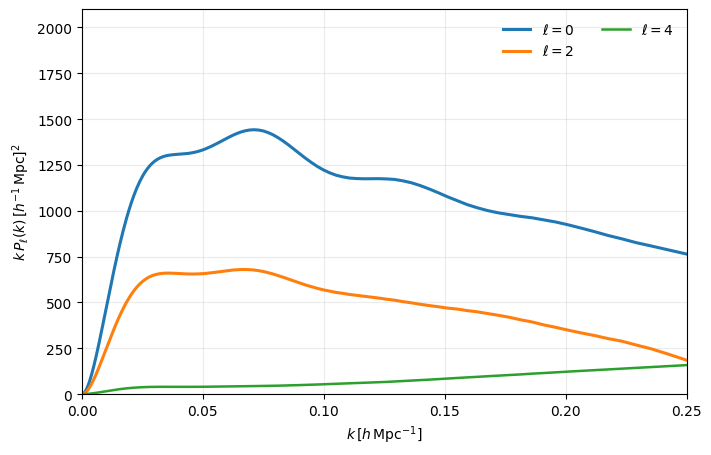

In [6]:
# ---- Plot: k P_ℓ(k) for ℓ = 0, 2, 4 (no AP) ----
fig, ax = plt.subplots(figsize=(7.8, 5.0))
ax.plot(kgrid, kgrid*P0, label=r"$\ell=0$", lw=2.2)
ax.plot(kgrid, kgrid*P2, label=r"$\ell=2$", lw=2.2)
ax.plot(kgrid, kgrid*P4, label=r"$\ell=4$", lw=1.8)
ax.set_xlim([0.0, 0.25]);
ax.set_ylim([0, 2100]);
ax.set_xlabel(r"$k\,[h\,\mathrm{Mpc}^{-1}]$")
ax.set_ylabel(r"$k\,P_\ell(k)\,[h^{-1}\,\mathrm{Mpc}]^2$")
ax.grid(True, alpha=0.25); ax.legend(frameon=False, ncol=2)
plt.show()

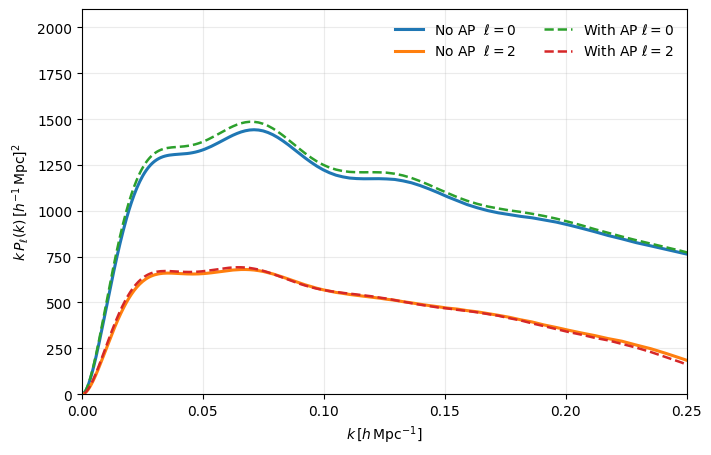

In [7]:
# ---- Optional: AP variant (Omfid for Alcock–Paczynski) & overlay ----
Omfid = 0.29                      # fiducial Omega_m for AP
k_AP, P0_AP, P2_AP, P4_AP = pyfkpt.rsd_multipoles(k=k_eval, nuis=nuis, z=z_pk, Om=Om, ap=True, tables=tables, Omfid=Omfid)

fig, ax = plt.subplots(figsize=(7.8, 5.0))
ax.plot(kgrid, kgrid*P0,     label=r"No AP  $\ell=0$",  lw=2.2)
ax.plot(kgrid, kgrid*P2,     label=r"No AP  $\ell=2$",  lw=2.2)
ax.plot(k_AP,   k_AP*P0_AP,  "--", label=r"With AP $\ell=0$", lw=1.8)
ax.plot(k_AP,   k_AP*P2_AP,  "--", label=r"With AP $\ell=2$", lw=1.8)
ax.set_xlim([0.0, 0.25]);
ax.set_ylim([0, 2100]);
ax.set_xlabel(r"$k\,[h\,\mathrm{Mpc}^{-1}]$")
ax.set_ylabel(r"$k\,P_\ell(k)\,[h^{-1}\,\mathrm{Mpc}]^2$")
ax.grid(True, alpha=0.25); ax.legend(frameon=False, ncol=2)
plt.show()

Running for f(R) gravity

In [8]:
# assumes you already have: params (base LCDM dict), k_camb, pk_camb, nuis, z_pk, Om
# and you've imported: import numpy as np; import pyfkpt.rsd as pyfkpt

# ---------- F4: |fR0| = 1e-4 ----------
p_F4 = dict(params)                 # start from your base params
p_F4["model"] = "HS"                # Hu–Sawicki branch
p_F4["fR0"]   = 1e-4                # |fR0| (signless magnitude for HS)
tabs_F4 = pyfkpt.compute_multipoles(k=k_camb, pk=pk_camb, **p_F4)

k_eval_F4 = np.asarray(tabs_F4["k"], float)
k_eval_F4 = k_eval_F4[(k_eval_F4 > 0) & (k_eval_F4 <= p_F4.get("kmax", k_eval_F4.max()))]

k_F4, P0_F4, P2_F4, P4_F4 = pyfkpt.rsd_multipoles(
    k=k_eval_F4, nuis=nuis, z=z_pk, Om=Om, ap=False, tables=tabs_F4
)

# ---------- F10: |fR0| = 1e-10 ----------
p_F10 = dict(params)
p_F10["model"] = "HS"
p_F10["fR0"]   = 1e-10
tabs_F10 = pyfkpt.compute_multipoles(k=k_camb, pk=pk_camb, **p_F10)

k_eval_F10 = np.asarray(tabs_F10["k"], float)
k_eval_F10 = k_eval_F10[(k_eval_F10 > 0) & (k_eval_F10 <= p_F10.get("kmax", k_eval_F10.max()))]

k_F10, P0_F10, P2_F10, P4_F10 = pyfkpt.rsd_multipoles(
    k=k_eval_F10, nuis=nuis, z=z_pk, Om=Om, ap=False, tables=tabs_F10
)


Running HS model
Running HS model

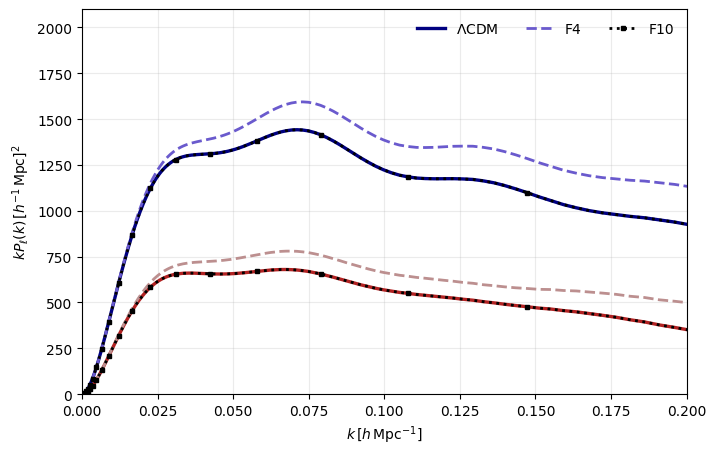

In [9]:
# ---- make the figure similar to your example (ℓ=0 and ℓ=2) ----
fig, ax = plt.subplots(figsize=(7.8, 5.0))

# ΛCDM (solid)
ax.plot(kgrid, kgrid*P0,  color="navy",      lw=2.4, label=r"$\Lambda$CDM")
ax.plot(kgrid, kgrid*P2,  color="firebrick", lw=2.4)

# F4 (dashed)
ax.plot(k_F4,  k_F4*P0_F4,  color="slateblue",  lw=2.0, ls="--", label="F4")
ax.plot(k_F4,  k_F4*P2_F4,  color="rosybrown",  lw=2.0, ls="--")

# F10 (dotted + small square markers to mimic the style)
ax.plot(k_F10, k_F10*P0_F10, color="black", lw=2.0, ls=":", marker="s", ms=3, markevery=12, label="F10")
ax.plot(k_F10, k_F10*P2_F10, color="black", lw=2.0, ls=":", marker="s", ms=3, markevery=12)

ax.set_xlim([0.0, 0.2]);
ax.set_ylim([0, 2100]);
ax.set_xlabel(r"$k\,[h\,\mathrm{Mpc}^{-1}]$")
ax.set_ylabel(r"$kP_\ell(k)\,[h^{-1}\,\mathrm{Mpc}]^2$")
ax.grid(True, alpha=0.25)
ax.legend(frameon=False, ncol=3, loc="upper right")
plt.show()